In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *


In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

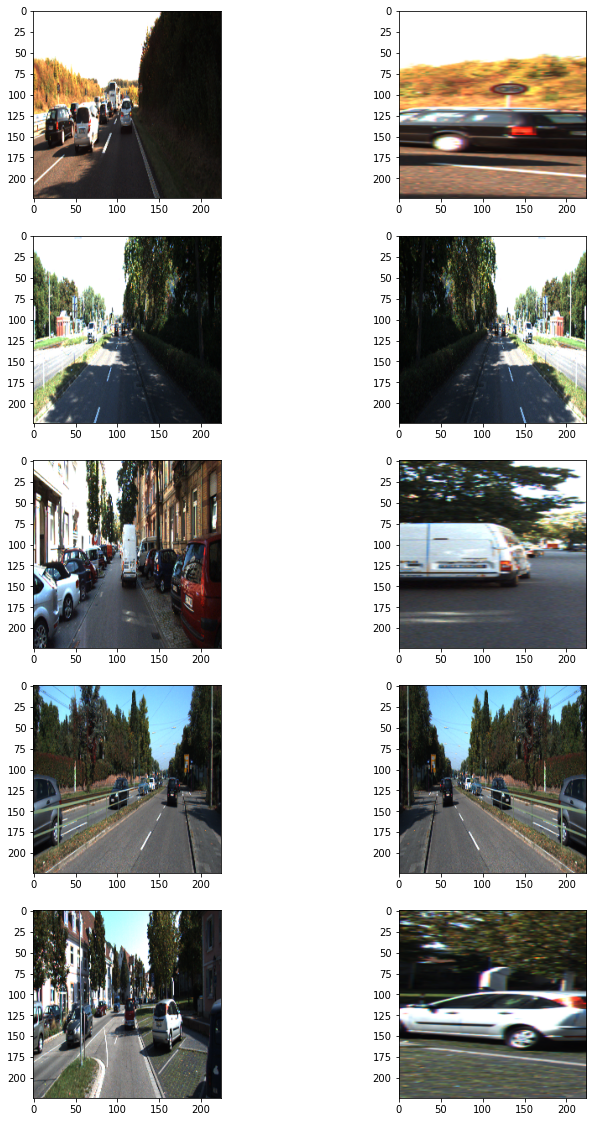

In [3]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'
augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [18]:
# def build_model(input_shape=(224, 224, 3)):
#     model = None
#     # TODO: input_shape에 따라 U-Net을 만들어주세요
#     # 이때 model은 fully convolutional해야 합니다.
#     return model
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([up1, conv2], axis=3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([up2, conv1], axis=3)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

    # Output layer
    output = Conv2D(1, (1, 1), activation='sigmoid')(conv5)

    model = Model(inputs=[inputs], outputs=[output])
    return model

In [6]:
def Transpose2D_block(filters, stage, cols, kernel_size=(3,3), upsample_rate=(2,2),
                      transpose_kernel_size=(4,4), use_batchnorm=False, skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name, merge_name = handle_block_names(stage, cols)

        x = Conv2DTranspose(filters, transpose_kernel_size, strides=upsample_rate,
                            padding='same', name=up_name, use_bias=not(use_batchnorm))(input_tensor)
        if use_batchnorm:
            x = BatchNormalization(name=bn_name+'1')(x)
        x = Activation('relu', name=relu_name+'1')(x)

        if (type(skip) != list and skip is not None) or (type(skip) == list and None not in skip):
            # print("\nskip = {}".format(skip))
            if type(skip) is list:
                merge_list = []
                merge_list.append(x)
                for l in skip:
                    merge_list.append(l)
                x = Concatenate(name=merge_name)(merge_list)
            else:
                x = Concatenate(name=merge_name)([x, skip])

        x = ConvRelu(filters, kernel_size, use_batchnorm=use_batchnorm,
                     conv_name=conv_name + '2', bn_name=bn_name + '2', relu_name=relu_name + '2')(x)

        return x
    return layer

In [7]:
def Upsample2D_block(filters, stage, cols, kernel_size=(3,3), upsample_rate=(2,2),
                     use_batchnorm=False, skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name, merge_name = handle_block_names(stage, cols)

        x = UpSampling2D(size=upsample_rate, name=up_name)(input_tensor)

        if (type(skip) != list and skip is not None) or (type(skip) == list and None not in skip):
            if type(skip) is list:
                x = Concatenate(name=merge_name)([x] + skip)
            else:
                x = Concatenate(name=merge_name)([x, skip])

        x = ConvRelu(filters, kernel_size, use_batchnorm=use_batchnorm,
                     conv_name=conv_name + '1', bn_name=bn_name + '1', relu_name=relu_name + '1')(x)

        x = ConvRelu(filters, kernel_size, use_batchnorm=use_batchnorm,
                     conv_name=conv_name + '2', bn_name=bn_name + '2', relu_name=relu_name + '2')(x)

        return x
    return layer


In [8]:
def build_xnet(backbone, classes, skip_connection_layers,
               decoder_filters=(256,128,64,32,16),
               upsample_rates=(2,2,2,2,2),
               n_upsample_blocks=5,
               block_type='upsampling',
               activation='sigmoid',
               use_batchnorm=True):

    input = backbone.input
    # print(n_upsample_blocks)

    if block_type == 'transpose':
        up_block = Transpose2D_block
    else:
        up_block = Upsample2D_block

    if len(skip_connection_layers) > n_upsample_blocks:
        downsampling_layers = skip_connection_layers[int(len(skip_connection_layers)/2):]
        skip_connection_layers = skip_connection_layers[:int(len(skip_connection_layers)/2)]
    else:
        downsampling_layers = skip_connection_layers


    # convert layer names to indices
    skip_connection_idx = ([get_layer_number(backbone, l) if isinstance(l, str) else l
                               for l in skip_connection_layers])
    skip_layers_list = [backbone.layers[skip_connection_idx[i]].output for i in range(len(skip_connection_idx))]
    downsampling_idx = ([get_layer_number(backbone, l) if isinstance(l, str) else l
                               for l in downsampling_layers])
    downsampling_list = [backbone.layers[downsampling_idx[i]].output for i in range(len(downsampling_idx))]
    downterm = [None] * (n_upsample_blocks+1)
    for i in range(len(downsampling_idx)):
        # print(downsampling_list[0])
        # print(backbone.output)
        # print("")
        if downsampling_list[0] == backbone.output:
            # print("VGG16 should be!")
            downterm[n_upsample_blocks-i] = downsampling_list[i]
        else:
            downterm[n_upsample_blocks-i-1] = downsampling_list[i]
    downterm[-1] = backbone.output
    # print("downterm = {}".format(downterm))

    interm = [None] * (n_upsample_blocks+1) * (n_upsample_blocks+1)
    for i in range(len(skip_connection_idx)):
        interm[-i*(n_upsample_blocks+1)+(n_upsample_blocks+1)*(n_upsample_blocks-1)] = skip_layers_list[i]
    interm[(n_upsample_blocks+1)*n_upsample_blocks] = backbone.output

    for j in range(n_upsample_blocks):
        for i in range(n_upsample_blocks-j):
            upsample_rate = to_tuple(upsample_rates[i])
            # print(j, i)
            
            if i == 0 and j < n_upsample_blocks-1 and len(skip_connection_layers) < n_upsample_blocks:
                interm[(n_upsample_blocks+1)*i+j+1] = None
            elif j == 0:
                if downterm[i+1] is not None:
                    interm[(n_upsample_blocks+1)*i+j+1] = up_block(decoder_filters[n_upsample_blocks-i-2], 
                                      i+1, j+1, upsample_rate=upsample_rate,
                                      skip=interm[(n_upsample_blocks+1)*i+j], 
                                      use_batchnorm=use_batchnorm)(downterm[i+1])
                else:
                    interm[(n_upsample_blocks+1)*i+j+1] = None
                # print("\n{} = {} + {}\n".format(interm[(n_upsample_blocks+1)*i+j+1],
                #                             interm[(n_upsample_blocks+1)*i+j], 
                #                             downterm[i+1]))
            else:
                interm[(n_upsample_blocks+1)*i+j+1] = up_block(decoder_filters[n_upsample_blocks-i-2], 
                                  i+1, j+1, upsample_rate=upsample_rate,
                                  skip=interm[(n_upsample_blocks+1)*i : (n_upsample_blocks+1)*i+j+1], 
                                  use_batchnorm=use_batchnorm)(interm[(n_upsample_blocks+1)*(i+1)+j])
                # print("\n{} = {} + {}\n".format(interm[(n_upsample_blocks+1)*i+j+1],
                #                             interm[(n_upsample_blocks+1)*i : (n_upsample_blocks+1)*i+j+1], 
                #                             interm[(n_upsample_blocks+1)*(i+1)+j]))
                
    # print('\n\n\n')
    # for x in range(n_upsample_blocks+1):
    #     for y in range(n_upsample_blocks+1):
    #         print(interm[x*(n_upsample_blocks+1)+y], end=' ', flush=True)
    #     print('\n')
    # print('\n\n\n')
    #print(interm)

    """
    for i in range(n_upsample_blocks-2):
        interm = []
        x = skip_layers_list[n_upsample_blocks-i-2]

    
    x = {}
    for stage in range(n_upsample_blocks-1):
        i = n_upsample_blocks - stage - 1
        x = backbone.layers[skip_connection_idx[i-1]].output
        for col in range(stage+1):
            print("i = {}, col = {}, index = {}".format(i, col, i+col))
            skip_connection = None
            if i-col < len(skip_connection_idx):
                skip_connection = skip_layers_list[i-col]
            upsample_rate = to_tuple(upsample_rates[i-col])
            x = up_block(decoder_filters[i-col], stage-col+1, col+1, upsample_rate=upsample_rate,
                         skip=skip_connection, use_batchnorm=use_batchnorm)(x)
            skip_layers_list[i+col] = x

    x = backbone.output
    for i in range(n_upsample_blocks):

        # check if there is a skip connection
        skip_connection = None
        if i < len(skip_connection_idx):
            # skip_connection = backbone.layers[skip_connection_idx[i]].output
            skip_connection = skip_layers_list[i]

        upsample_rate = to_tuple(upsample_rates[i])

        x = up_block(decoder_filters[i], n_upsample_blocks-i, 0, upsample_rate=upsample_rate,
                     skip=skip_connection, use_batchnorm=use_batchnorm)(x)
    """

    """
    i = n_upsample_blocks - 1
    xx = backbone.layers[skip_connection_idx[i-0-1]].output
    skip_connection = skip_layers_list[i-0]
    upsample_rate = to_tuple(upsample_rates[i-0])
    xx = up_block(decoder_filters[i-0], n_upsample_blocks-i-0, 1+0, upsample_rate=upsample_rate,
                 skip=skip_connection, use_batchnorm=use_batchnorm)(xx)
    skip_layers_list[i-0] = xx

    i = n_upsample_blocks - 2
    xx = backbone.layers[skip_connection_idx[i-0-1]].output

    skip_connection = skip_layers_list[i-0]
    upsample_rate = to_tuple(upsample_rates[i-0])
    xx = up_block(decoder_filters[i-0], n_upsample_blocks-i-0, 1+0, upsample_rate=upsample_rate,
                 skip=skip_connection, use_batchnorm=use_batchnorm)(xx)
    skip_layers_list[i-0] = xx

    skip_connection = skip_layers_list[i-1]
    upsample_rate = to_tuple(upsample_rates[i-1])
    xx = up_block(decoder_filters[i-1], n_upsample_blocks-i-1, 1+1, upsample_rate=upsample_rate,
                 skip=skip_connection, use_batchnorm=use_batchnorm)(xx)
    skip_layers_list[i-1] = xx
    """
    
    """
    for i in range(n_upsample_blocks):

        # check if there is a skip connection
        skip_connection = None
        if i < len(skip_connection_idx):
            # skip_connection = backbone.layers[skip_connection_idx[i]].output
            skip_connection = skip_layers_list[i]

        upsample_rate = to_tuple(upsample_rates[i])

        x = up_block(decoder_filters[i], n_upsample_blocks-i, 0, upsample_rate=upsample_rate,
                     skip=skip_connection, use_batchnorm=use_batchnorm)(x)
    """

    x = Conv2D(classes, (3,3), padding='same', name='final_conv')(interm[n_upsample_blocks])
    x = Activation(activation, name=activation)(x)

    model = Model(input, x)

    return model

In [10]:
DEFAULT_SKIP_CONNECTIONS = {
    'vgg16':            ('block5_conv3', 'block4_conv3', 'block3_conv3', 'block2_conv2', 'block1_conv2',
                         'block5_pool', 'block4_pool', 'block3_pool', 'block2_pool', 'block1_pool',
                        ),
    'vgg19':            ('block5_conv4', 'block4_conv4', 'block3_conv4', 'block2_conv2', 'block1_conv2',
                         'block5_pool', 'block4_pool', 'block3_pool', 'block2_pool', 'block1_pool',
                        ),
    'resnet18':         ('stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0',
                         'relu1', 'stage3_unit2_relu1', 'stage2_unit2_relu1', 'stage1_unit2_relu1',
                        ),
    'resnet34':         ('stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0',
                         'relu1', 'stage3_unit2_relu1', 'stage2_unit2_relu1', 'stage1_unit2_relu1',
                        ),
    'resnet50':         ('stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0',
                         'relu1', 'stage3_unit2_relu1', 'stage2_unit2_relu1', 'stage1_unit2_relu1',
                        ),
    'resnet101':        ('stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0',
                         'relu1', 'stage3_unit2_relu1', 'stage2_unit2_relu1', 'stage1_unit2_relu1',
                        ),
    'resnet152':        ('stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0',
                         'relu1', 'stage3_unit2_relu1', 'stage2_unit2_relu1', 'stage1_unit2_relu1',
                        ),
    'resnext50':        ('stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0',
                         'stage4_unit1_relu1', 'stage3_unit2_relu1', 'stage2_unit2_relu1', 'stage1_unit2_relu1',
                        ),
    'resnext101':       ('stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0',
                         'stage4_unit1_relu1', 'stage3_unit2_relu1', 'stage2_unit2_relu1', 'stage1_unit2_relu1',
                        ),
    'inceptionv3':          (228, 86, 16, 9),
    'inceptionresnetv2':    (594, 260, 16, 9),
    'densenet121':          (311, 139, 51, 4),
    'densenet169':          (367, 139, 51, 4),
    'densenet201':          (479, 139, 51, 4),
}

In [11]:
def get_backbone(name, *args, **kwargs):
    return backbones[name](*args, **kwargs)

In [9]:

def Xnet(backbone_name='vgg16',
         input_shape=(None, None, 3),
         input_tensor=None,
         encoder_weights='imagenet',
         freeze_encoder=False,
         skip_connections='default',
         decoder_block_type='upsampling',
         decoder_filters=(256,128,64,32,16),
         decoder_use_batchnorm=True,
         n_upsample_blocks=5,
         upsample_rates=(2,2,2,2,2),
         classes=1,
         activation='sigmoid'):
    """

    Args:
        backbone_name: (str) look at list of available backbones.
        input_shape:  (tuple) dimensions of input data (H, W, C)
        input_tensor: keras tensor
        encoder_weights: one of `None` (random initialization), 
            'imagenet' (pre-training on ImageNet), 
            'dof' (pre-training on DoF)
        freeze_encoder: (bool) Set encoder layers weights as non-trainable. Useful for fine-tuning
        skip_connections: if 'default' is used take default skip connections,
            else provide a list of layer numbers or names starting from top of model
        decoder_block_type: (str) one of 'upsampling' and 'transpose' (look at blocks.py)
        decoder_filters: (int) number of convolution layer filters in decoder blocks
        decoder_use_batchnorm: (bool) if True add batch normalisation layer between `Conv2D` ad `Activation` layers
        n_upsample_blocks: (int) a number of upsampling blocks
        upsample_rates: (tuple of int) upsampling rates decoder blocks
        classes: (int) a number of classes for output
        activation: (str) one of keras activations for last model layer

    Returns:
        keras.models.Model instance

    """



    backbone = get_backbone(backbone_name,
                            input_shape=input_shape,
                            input_tensor=input_tensor,
                            weights=encoder_weights,
                            include_top=False)

    if skip_connections == 'default':
        skip_connections = DEFAULT_SKIP_CONNECTIONS[backbone_name]
    # n_upsample_blocks = len(skip_connections)

    model = build_xnet(backbone,
                       classes,
                       skip_connections,
                       decoder_filters=decoder_filters,
                       block_type=decoder_block_type,
                       activation=activation,
                       n_upsample_blocks=n_upsample_blocks,
                       upsample_rates=upsample_rates,
                       use_batchnorm=decoder_use_batchnorm)

    # lock encoder weights for fine-tuning
    if freeze_encoder:
        freeze_model(backbone)

    model.name = 'x-{}'.format(backbone_name)

    return model

In [17]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    return x

def build_unet_plus_plus(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(pool3, 512)

    # Bridge
    bridge = conv_block(conv4, 1024)

    # Decoder
    up4 = UpSampling2D(size=(2, 2))(bridge)
    conv4_up = concatenate([conv4, up4])
    conv4_up = conv_block(conv4_up, 512)

    up3 = UpSampling2D(size=(2, 2))(conv4_up)
    conv3_up = concatenate([conv3, up3, UpSampling2D(size=(2, 2))(conv4)])
    conv3_up = conv_block(conv3_up, 256)

    up2 = UpSampling2D(size=(2, 2))(conv3_up)
    conv2_up = concatenate([conv2, up2, UpSampling2D(size=(2, 2))(conv3)])
    conv2_up = conv_block(conv2_up, 128)

    up1 = UpSampling2D(size=(2, 2))(conv2_up)
    conv1_up = concatenate([conv1, up1, UpSampling2D(size=(2, 2))(conv2)])
    conv1_up = conv_block(conv1_up, 64)

    # Output layer
    output = Conv2D(1, (1, 1), activation='sigmoid')(conv1_up)

    model = Model(inputs=[inputs], outputs=[output])
    return model

In [19]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
with tf.device("/gpu:0"):
    model.fit(
        train_generator,
        validation_data=test_generator,
        steps_per_epoch=len(train_generator),
        epochs=100,
    )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 9s 442ms/step - loss: 0.6800 - val_loss: 0.6489
Epoch 2/100
11/11 [==============================] - 5s 426ms/step - loss: 0.5689 - val_loss: 0.3285
Epoch 3/100
11/11 [==============================] - 5s 429ms/step - loss: 0.1635 - val_loss: 0.0427
Epoch 4/100
11/11 [==============================] - 5s 426ms/step - loss: 0.0367 - val_loss: 0.0337
Epoch 5/100
11/11 [==============================] - 5s 412ms/step - loss: 0.0258 - val_loss: 0.0419
Epoch 6/100
11/11 [==============================] - 5s 409ms/step - loss: 0.0295 - val_loss: 0.0299
Epoch 7/100
11/11 [==============================] - 4s 405ms/step - loss: 0.0238 - val_loss: 0.0297
Epoch 8/100
11/11 [==============================] - 4s 404ms/step - loss: 0.0278 - val_loss: 0.0284
Epoch 9/100
11/11 [==============================] - 4s 401ms/step - loss: 0.0268 - val_loss: 0.0288
Epoch 10/100
11/11 [==============================] - 4s 402ms/step - loss: 0.0243 - val_lo

In [7]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus.h5'

model = build_unet_plus_plus()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
with tf.device("/gpu:0"):
    model.fit(
        train_generator,
        validation_data=test_generator,
        steps_per_epoch=len(train_generator),
        epochs=100,
    )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 22s 743ms/step - loss: 0.6819 - val_loss: 0.6464
Epoch 2/100
11/11 [==============================] - 8s 723ms/step - loss: 0.5544 - val_loss: 0.3082
Epoch 3/100
11/11 [==============================] - 8s 731ms/step - loss: 0.1211 - val_loss: 0.0579
Epoch 4/100
11/11 [==============================] - 8s 732ms/step - loss: 0.0331 - val_loss: 0.0349
Epoch 5/100
11/11 [==============================] - 8s 729ms/step - loss: 0.0285 - val_loss: 0.0399
Epoch 6/100
11/11 [==============================] - 8s 736ms/step - loss: 0.0338 - val_loss: 0.0317
Epoch 7/100
11/11 [==============================] - 8s 743ms/step - loss: 0.0253 - val_loss: 0.0323
Epoch 8/100
11/11 [==============================] - 8s 743ms/step - loss: 0.0266 - val_loss: 0.0298
Epoch 9/100
11/11 [==============================] - 8s 754ms/step - loss: 0.0240 - val_loss: 0.0302
Epoch 10/100
11/11 [==============================] - 8s 760ms/step - loss: 0.0261 - val_l

In [8]:
# 미리 준비한 모델을 불러오려면 아래 주석을 해제하세요
# model_path = dir_path + '/seg_model_unet.h5' 

model = tf.keras.models.load_model(model_path)

In [9]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output

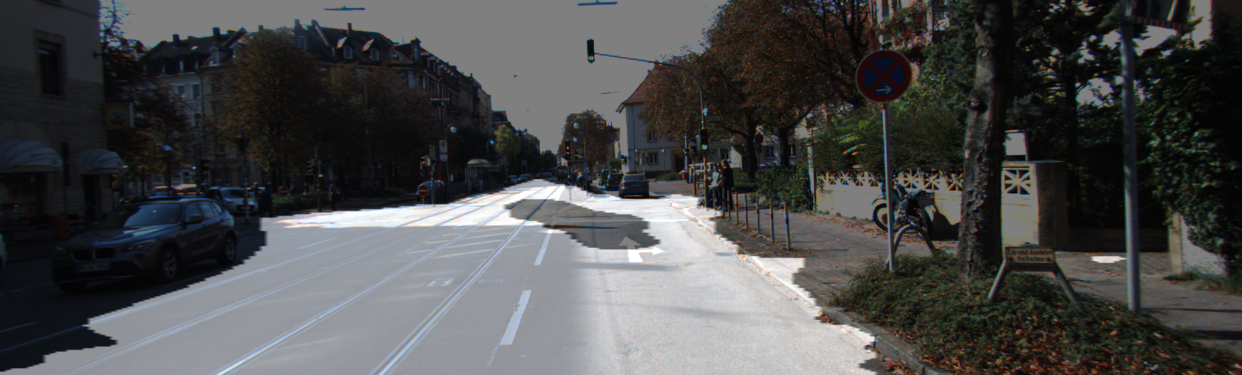

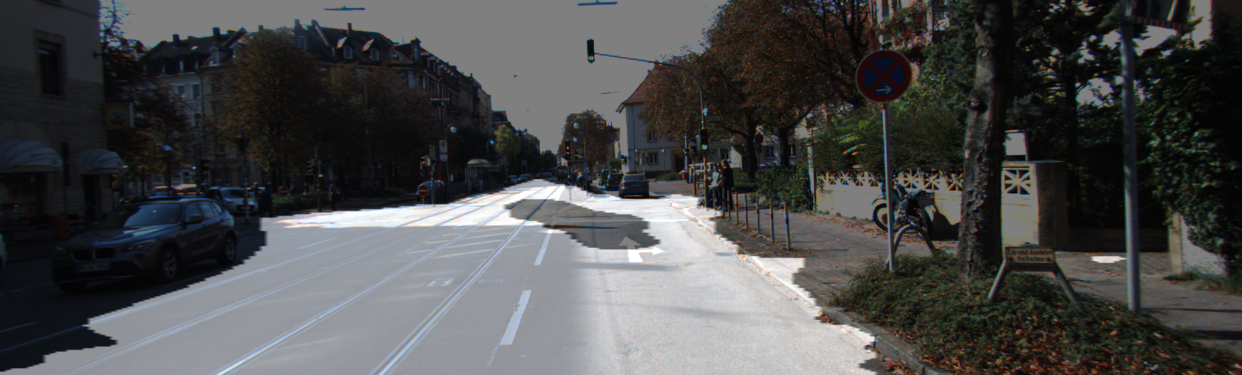

In [10]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [11]:
def calculate_iou_score(target, prediction):
    # Calculate intersection
    intersection = tf.logical_and(target, prediction)
    intersection = tf.reduce_sum(tf.cast(intersection, tf.float32))

    # Calculate union
    union = tf.logical_or(target, prediction)
    union = tf.reduce_sum(tf.cast(union, tf.float32))

    # Calculate IoU score
    iou_score = intersection / union
    print('IoU : %f' % iou_score )
    return iou_score

In [12]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

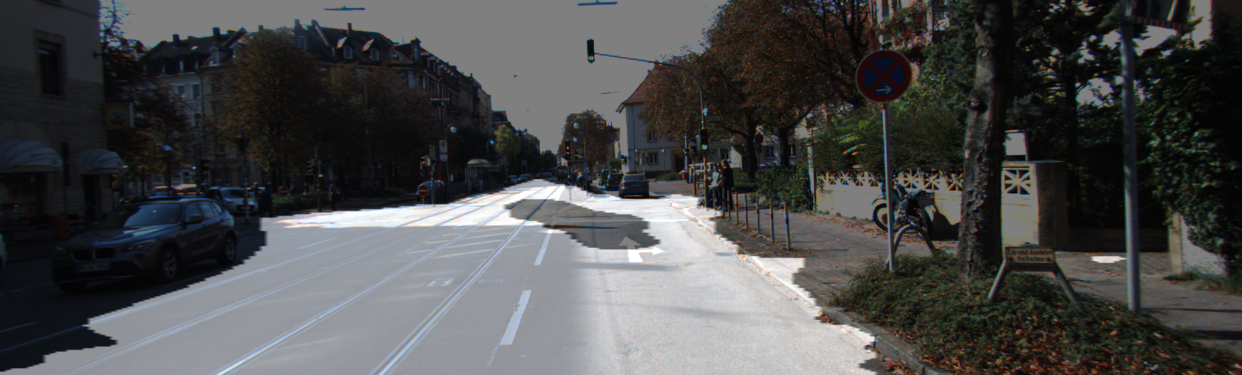

IoU : 0.827838


<tf.Tensor: shape=(), dtype=float32, numpy=0.8278377>

In [13]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

In [20]:
# 미리 준비한 모델을 불러오려면 아래 주석을 해제하세요
model_path = dir_path + '/seg_model_unet.h5' 

model2 = tf.keras.models.load_model(model_path)

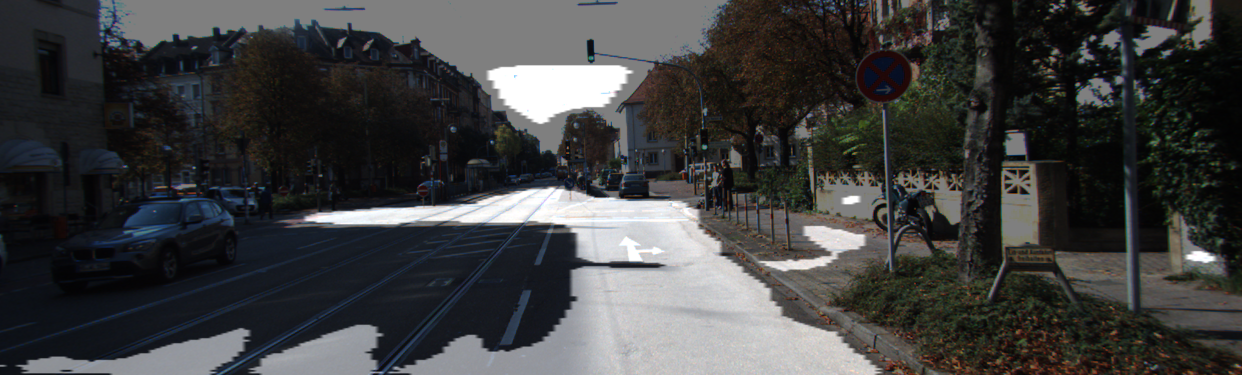

IoU : 0.419641


<tf.Tensor: shape=(), dtype=float32, numpy=0.4196409>

In [21]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model2, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

#  회고

제대로 학습에 집중을 하지못했던것, dice coeffiecent 와 등 추가적인 작업들을 하지 못햇던것 같다.
다음 부터는 GPT에 의존도를 줄이고 제대로 집중해서 해야될것같다. 이번 노드는 방학때 다시 공부해야될것 같다.